# Hantush response functions

This notebook compares the two Hantush response function implementations in Pastas.

*Developed by D.A. Brakenhoff (Artesia, 2021)*


## Contents

- [`Hantush` versus `HantushWellModel`](#`Hantush`-versus-`HantushWellModel`)
- [Which Hantush should I use?](#Which-Hantush-should-I-use?)
- [Synthetic example](#Synthetic-example)

In [1]:
import numpy as np
import pandas as pd
import pastas as ps

ps.show_versions()

Python version: 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
Numpy version: 1.20.1
Scipy version: 1.5.2
Pandas version: 1.1.5
Pastas version: 0.17.0b
Matplotlib version: 3.3.3


## `Hantush` versus `HantushWellModel`

The reason there are two implementations in Pastas is that each implementation currently has advantages and disadvantages. We will discuss those soon, but first let's introduce the two implementations. The two Hantush response functions are very similar, but differ in the definition of the parameters. The table below shows the formulas for both implementations.


| Name             | Parameters  | Formula                                                                 | Description                                                                    |
|------------------|-------------|:------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| Hantush          | 3 - A, a, b | $$ \theta(t) = At^{-1} e^{-t/a - ab/t} $$                               | Response function commonly used for groundwater abstraction wells.             |
| HantushWellModel | 3 - A, a, b | $$ \theta(t) = A K_0 \left( \sqrt{4b} \right) t^{-1} e^{-t/a - ab/t} $$ | Implementation of the Hantush well function that allows scaling with distance. |

In the first implementation the parameters $A$, $a$, and $b$ can be written as:

$$
\begin{align}
A &= \frac{1}{2 \pi T} K_0 \left( \sqrt{4b} \right) \\
a &= cS \\
b &= \frac{r^2}{4 \lambda^2}
\end{align}
$$

In this case parameter $A$ is also known as the "gain", which is equal to the steady-state contribution of a stress with unit 1. For example, the drawdown caused by a well with a continuous extraction rate of 1.0 (the units don't really matter here and are determined by what units the user puts in).

In the second implementation, the definition of the parameters $A$ is different, which allows the distance $r$ between an extraction well and an observation well to be passed as a variable. This allows multiple wells to have the same response function, which can be useful for example, to reduce the number of parameters in a model with multiple extraction wells. When $r$ is passed as a parameter, the formula for $b$ below is simplified by substituting in $1$ for $r$. Note that $r$ is never optimized, but has to be provided by the user.

$$
\begin{align}
A &= \frac{1}{2 \pi T} \\
a &= cS \\
b &= \frac{r^2}{4 \lambda^2}
\end{align}
$$

## Which Hantush should I use?

So why two implementations? Well, there are advantages and disadvantages to both implementations, which are listed in the table below.

|Name | Pro| Con|
|:--|:----|:-----|
|**Hantush**|<ul><li>Parameter A is the gain, which makes it easier to interpret the results.</li>    <li>Estimates the uncertainty of the gain directly.</li></ul>|<ul><li>Cannot be used to simulate multiple wells.</li><li>More challenging to relate to aquifer characteristics.</li></ul>|
|**HantushWellModel**|<ul><li>Can be used with WellModel to simulate multiple wells with one response function.</li><li>Easier to relate parameters to aquifer characteristics.</li></ul>|<ul><li>Does not directly estimate the uncertainty of the gain.</li><li>More sensitive to the initial value of parameters, in rare cases the initial parameter values have to be tweaked to get a good fit result.</li></ul>|


So which one should you use? It depends on your use-case:

- Use `Hantush` if you are considering a single extraction well and you're interested in calculating the gain and the uncertainty of the gain.
- Use `HantushWellModel` if you are simulating multiple extraction wells or want to pass the distance between extraction and observation well as a known parameter.

Of course these aren't strict rules and it is encouraged to explore different model structures when building your timeseries models. But as a first general guiding principle this should help in selecting which approach is appropriate for your specific problem. 

## Synthetic example 

A synthetic example is used to show both Hantush implementations. First, we create a synthetic timeseries generated with the Hantush response function to which we add autocorrelated residuals. We set the parameter values for the Hantush response function:

In [2]:
# A defined so that 100 m3/day results in 5 m drawdown
A = -5 / 100.0 
a = 200
b = 0.5

d = 0.0  # reference level

In [3]:
# auto-correlated residuals AR(1)
sigma_n = 0.05
alpha = 50
sigma_r = sigma_n / np.sqrt(1 - np.exp(-2 * 14 / alpha))
print(f'sigma_r = {sigma_r:.2f} m')

sigma_r = 0.08 m


Create a head observations timeseries and a timeseries with the well extraction rate.

In [4]:
# head observations between 2000 and 2010
idx = pd.date_range("2000", "2010", freq="D")
ho = pd.Series(index=idx, data=0)

# extraction of 100 m3/day between 2002 and 2006
well = pd.Series(index=idx, data=0.0)
well.loc["2002":"2006"] = 100.0

Create the synthetic head timeseries based on the extraction rate and the parameters we defined above.

In [5]:
ml0 = ps.Model(ho) # alleen de tijdstippen waarop gemeten is worden gebruikt
rm = ps.StressModel(well, ps.Hantush, name='well', up=False)
ml0.add_stressmodel(rm)
ml0.set_parameter('well_A', initial=A)
ml0.set_parameter('well_a', initial=a)
ml0.set_parameter('well_b', initial=b)
ml0.set_parameter('constant_d', initial=d)
hsynthetic_no_error = ml0.simulate()[ho.index]

INFO: Time series None updated to dtype float.
INFO: Inferred frequency for time series None: freq=D
INFO: Inferred frequency for time series None: freq=D


Add the auto-correlated residuals.

In [6]:
delt = (ho.index[1:] - ho.index[:-1]).values / pd.Timedelta("1d")
np.random.seed(1)
noise = sigma_n * np.random.randn(len(ho))
residuals = np.zeros_like(noise)
residuals[0] = noise[0]
for i in range(1, len(ho)):
    residuals[i] = np.exp(-delt[i - 1] / alpha) * residuals[i - 1] + noise[i]
hsynthetic = hsynthetic_no_error + residuals

Plot the timeseries.

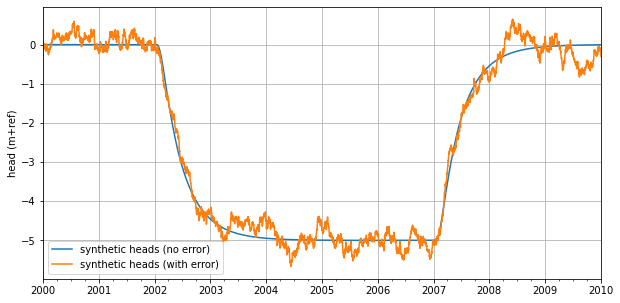

In [7]:
ax = hsynthetic_no_error.plot(label='synthetic heads (no error)', figsize=(10, 5))
hsynthetic.plot(ax=ax, color="C1", label="synthetic heads (with error)")
ax.legend(loc='best')
ax.set_ylabel("head (m+ref)")
ax.grid(b=True)

Create three models:

1. Model with `Hantush` response function.
2. Model with `HantushWellModel` response function, but $r$ is not passed as a known parameter.
3. Model with `WellModel`, which uses `HantushWellModel` and where $r$ is set to 1.0 m.

All three models should yield the similar results and be able to estimate the true values of the parameters reasonably well.

In [8]:
# Hantush
ml_h1 = ps.Model(hsynthetic, name="gain")
wm_h1 = ps.StressModel(well, ps.Hantush, name='well', up=False)
ml_h1.add_stressmodel(wm_h1)
ml_h1.solve(report=False, noise=True)

INFO: Inferred frequency for time series Simulation: freq=D
INFO: Inferred frequency for time series None: freq=D


Solve with noise model and Hantush_scaled

In [9]:
# HantushWellModel
ml_h2 = ps.Model(hsynthetic, name="scaled")
wm_h2 = ps.StressModel(well, ps.HantushWellModel, name='well', up=False)
ml_h2.add_stressmodel(wm_h2)
ml_h2.solve(report=False, noise=True)

INFO: Inferred frequency for time series Simulation: freq=D
INFO: Inferred frequency for time series None: freq=D


In [10]:
# WellModel
r = np.array([1.0])  # parameter r
well.name = "well"

ml_h3 = ps.Model(hsynthetic, name="wellmodel")
wm_h3 = ps.WellModel([well], ps.HantushWellModel, "well", r, up=False)
ml_h3.add_stressmodel(wm_h3)
ml_h3.solve(report=False, noise=True, solver=ps.LmfitSolve)

INFO: Inferred frequency for time series Simulation: freq=D
INFO: Inferred frequency for time series well: freq=D
INFO: Time Series well was extended to 1990-01-03 00:00:00 by adding 0.0 values.


Plot a comparison of all three models. The three models all yield similar results (all the lines overlap). 

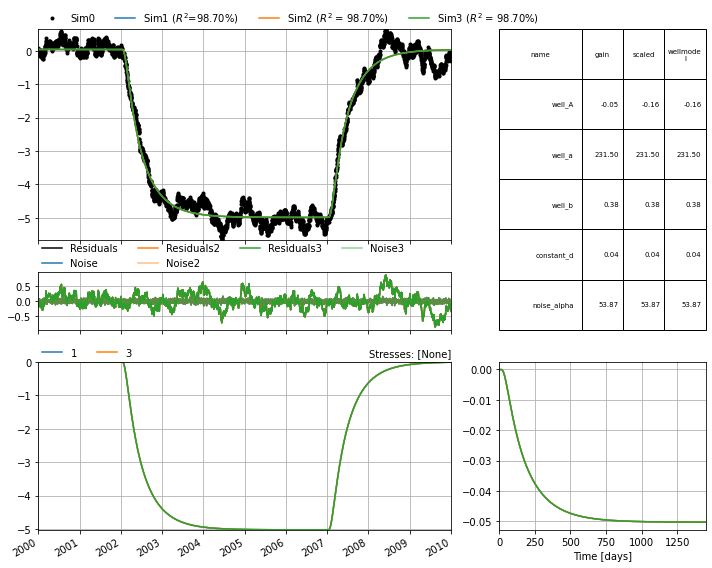

In [11]:
axes = ps.plots.compare([ml_h1, ml_h2, ml_h3], adjust_height=True, 
                        figsize=(10, 8));

Compare the optimized parameters for each model with the true values we defined at the beginning of this example. Note that we're comparing the value of the gain (not parameter $A$) and that each model has its own method for calculating the gain. As expected, the parameter estimates are reasonably close to the true values defined above.

In [12]:
df = pd.DataFrame(index=["well_gain", "well_a", "well_b"], 
                  columns=["True value", "Hantush", 
                           "HantushWellModel", "WellModel"])

df["True value"] = A, a, b

df["Hantush"] = (
    # gain (same as A in this case)
    wm_h1.rfunc.gain(ml_h1.get_parameters("well")),
    # a
    ml_h1.parameters.loc["well_a", "optimal"],
    # b
    ml_h1.parameters.loc["well_b", "optimal"] 
)

df["HantushWellModel"] = (
    # gain (not same as A)
    wm_h2.rfunc.gain(ml_h2.get_parameters("well")), 
    # a
    ml_h2.parameters.loc["well_a", "optimal"],
    # b
    ml_h2.parameters.loc["well_b", "optimal"]
)

df["WellModel"] = (
    # gain, use WellModel.get_parameters() to get params: A, a, b and r
    wm_h3.rfunc.gain(wm_h3.get_parameters(model=ml_h3, istress=0)),  
    # a
    ml_h3.parameters.loc["well_a", "optimal"],  
    # b (multiply parameter value by r^2 for comparison)
    ml_h3.parameters.loc["well_b", "optimal"] * r[0]**2  
)

df

,True value,Hantush,HantushWellModel,WellModel
well_gain,-0.05,-0.050272,-0.050272,-0.050272
well_a,200.00,231.499643,231.497858,231.498489
well_b,0.50,0.376504,0.376513,0.376509
